In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

print("All libraries imported successfully.")

All libraries imported successfully.


In [60]:
# Define paths
data_dir = "../data/splits"
train_path = os.path.join(data_dir, "train.csv")
val_path = os.path.join(data_dir, "validation.csv")
test_path = os.path.join(data_dir, "test.csv")

# Load datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

print(f"Train set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Train set: (3469, 41)
Validation set: (743, 41)
Test set: (744, 41)


In [61]:
# Target column
target_col = 'price'

# Features: all columns except target
feature_cols = [col for col in train_df.columns if col != target_col]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print("Features and target separated.")
print(f"Number of features: {len(feature_cols)}")

Features and target separated.
Number of features: 40


In [62]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """Calculate metrics on train and validation sets."""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    # Store in dictionary
    metrics = {
        'Model': model_name,
        'Train RMSE': train_rmse,
        'Validation RMSE': val_rmse,
        'Train MAE': train_mae,
        'Validation MAE': val_mae,
        'Train R2': train_r2,
        'Validation R2': val_r2
    }

    # Print
    print(f"\n{model_name} Performance:")
    print(f"  Train RMSE: {train_rmse:.4f} | Validation RMSE: {val_rmse:.4f}")
    print(f"  Train MAE : {train_mae:.4f} | Validation MAE : {val_mae:.4f}")
    print(f"  Train R2  : {train_r2:.4f} | Validation R2  : {val_r2:.4f}")

    return metrics, y_train_pred, y_val_pred

In [63]:
# Create XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)

# Train with evaluation set to capture history
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

# Evaluate
xgb_metrics, xgb_train_pred, xgb_val_pred = evaluate_model(xgb_model, X_train, y_train, X_val, y_val, "XGBoost")

# Store the model for later use
models = {'XGBoost': xgb_model}


XGBoost Performance:
  Train RMSE: 12.6092 | Validation RMSE: 50.2281
  Train MAE : 9.1820 | Validation MAE : 30.4763
  Train R2  : 0.9863 | Validation R2  : 0.7454


In [64]:
# Create LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42, n_estimators=100, verbosity=-1)

# Prepare a dictionary to store evaluation results
evals_result = {}

# Train with evaluation set and capture history
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(10), lgb.record_evaluation(evals_result)]
)

# No manual assignment needed; the model's evals_result_ is automatically set.

# Evaluate
lgb_metrics, lgb_train_pred, lgb_val_pred = evaluate_model(lgb_model, X_train, y_train, X_val, y_val, "LightGBM")

models['LightGBM'] = lgb_model

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	training's rmse: 39.1773	training's l2: 1534.86	valid_1's rmse: 48.7715	valid_1's l2: 2378.66

LightGBM Performance:
  Train RMSE: 39.1773 | Validation RMSE: 48.7715
  Train MAE : 24.3079 | Validation MAE : 31.2987
  Train R2  : 0.8673 | Validation R2  : 0.7599


In [65]:
# Create CatBoost model
cb_model = cb.CatBoostRegressor(random_seed=42, iterations=100, verbose=False)

# Train with evaluation set
cb_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=False
)

# Evaluate
cb_metrics, cb_train_pred, cb_val_pred = evaluate_model(cb_model, X_train, y_train, X_val, y_val, "CatBoost")

models['CatBoost'] = cb_model


CatBoost Performance:
  Train RMSE: 36.6348 | Validation RMSE: 56.1925
  Train MAE : 25.3948 | Validation MAE : 32.8548
  Train R2  : 0.8840 | Validation R2  : 0.6813


Model Comparison (Validation Set):
          Validation RMSE  Validation MAE  Validation R2
Model                                                   
XGBoost           50.2281         30.4763         0.7454
LightGBM          48.7715         31.2987         0.7599
CatBoost          56.1925         32.8548         0.6813


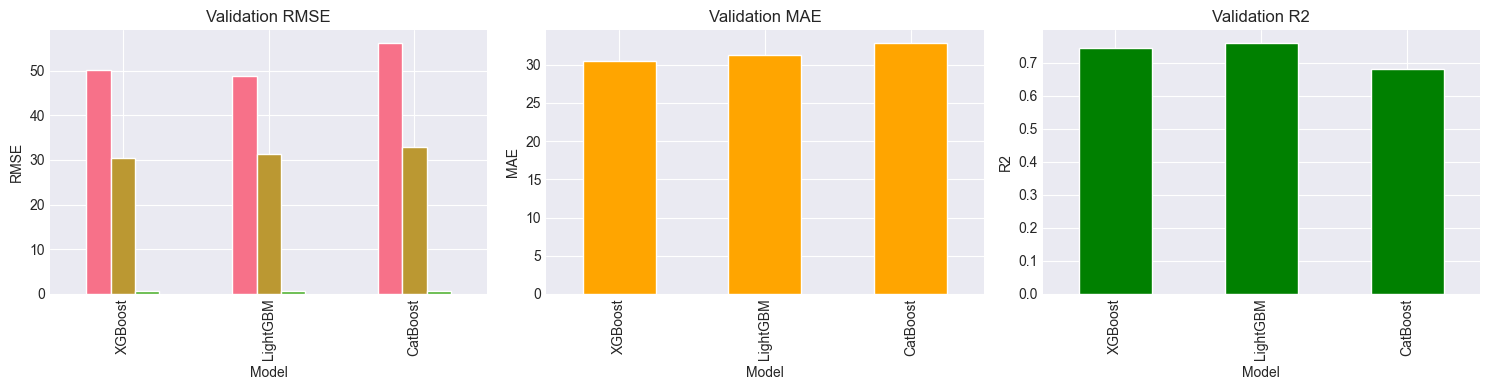

In [66]:
# Combine all metrics into a DataFrame
metrics_list = [xgb_metrics, lgb_metrics, cb_metrics]
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Model', inplace=True)

print("Model Comparison (Validation Set):")
print(metrics_df[['Validation RMSE', 'Validation MAE', 'Validation R2']].round(4))

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics_df[['Validation RMSE', 'Validation MAE', 'Validation R2']].plot(kind='bar', ax=axes[0], legend=False)
axes[0].set_title('Validation RMSE')
axes[0].set_ylabel('RMSE')

metrics_df[['Validation MAE']].plot(kind='bar', ax=axes[1], legend=False, color='orange')
axes[1].set_title('Validation MAE')
axes[1].set_ylabel('MAE')

metrics_df[['Validation R2']].plot(kind='bar', ax=axes[2], legend=False, color='green')
axes[2].set_title('Validation R2')
axes[2].set_ylabel('R2')

plt.tight_layout()
plt.show()

LightGBM evals_result_ keys: dict_keys(['training', 'valid_1'])
Using validation key: valid_1
CatBoost evals_result keys: dict_keys(['learn', 'validation'])


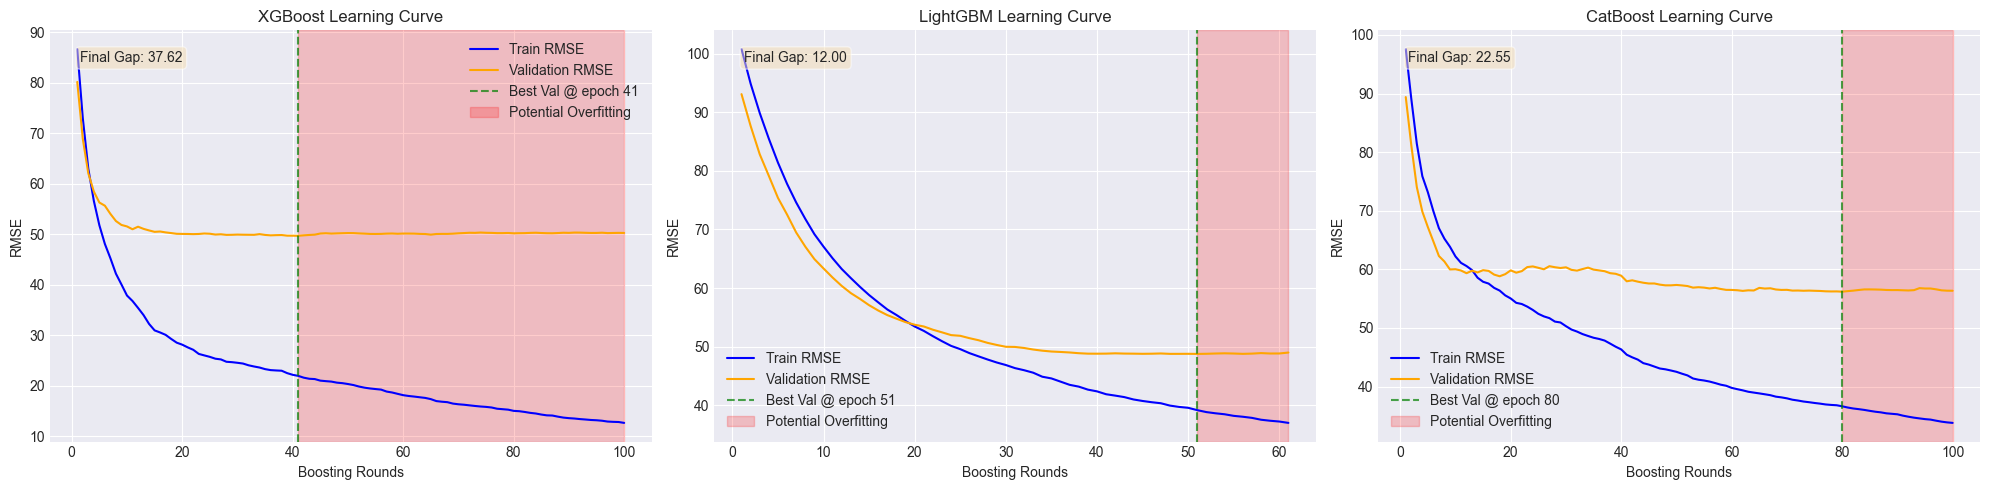

In [67]:
# Extract evaluation history from each model

# --- XGBoost ---
xgb_results = xgb_model.evals_result()
xgb_train_rmse = xgb_results['validation_0']['rmse']
xgb_val_rmse = xgb_results['validation_1']['rmse']

# --- LightGBM ---
lgb_results = lgb_model.evals_result_
print("LightGBM evals_result_ keys:", lgb_results.keys())
# Dynamically find the validation key
lgb_train_key = 'training'
lgb_val_key = None
for key in lgb_results.keys():
    if key != lgb_train_key:
        lgb_val_key = key
        break
if lgb_val_key is None:
    raise ValueError("Could not find validation key in LightGBM evals_result_")
print(f"Using validation key: {lgb_val_key}")
lgb_train_rmse = lgb_results[lgb_train_key]['rmse']
lgb_val_rmse = lgb_results[lgb_val_key]['rmse']

# --- CatBoost ---
cb_results = cb_model.get_evals_result()
print("CatBoost evals_result keys:", cb_results.keys())
cb_train_rmse = cb_results['learn']['RMSE']
cb_val_rmse = cb_results['validation']['RMSE']

# ---- Function to plot learning curve with overfitting indicators ----
def plot_learning_curve_with_overfitting(ax, train_errors, val_errors, model_name):
    epochs = range(1, len(train_errors)+1)
    ax.plot(epochs, train_errors, label='Train RMSE', color='blue')
    ax.plot(epochs, val_errors, label='Validation RMSE', color='orange')

    # Find the point where validation error is minimum (best iteration)
    best_epoch = np.argmin(val_errors) + 1
    best_val = val_errors[best_epoch-1]
    ax.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Val @ epoch {best_epoch}')

    # Shade the region after best epoch if validation error increases (overfitting)
    if best_epoch < len(val_errors):
        ax.axvspan(best_epoch, len(val_errors), alpha=0.2, color='red', label='Potential Overfitting')

    # Compute final gap
    final_gap = val_errors[-1] - train_errors[-1]
    ax.text(0.05, 0.95, f'Final Gap: {final_gap:.2f}', transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_title(f'{model_name} Learning Curve')
    ax.set_xlabel('Boosting Rounds')
    ax.set_ylabel('RMSE')
    ax.legend()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_learning_curve_with_overfitting(axes[0], xgb_train_rmse, xgb_val_rmse, 'XGBoost')
plot_learning_curve_with_overfitting(axes[1], lgb_train_rmse, lgb_val_rmse, 'LightGBM')
plot_learning_curve_with_overfitting(axes[2], cb_train_rmse, cb_val_rmse, 'CatBoost')

plt.tight_layout()
plt.show()

Overfitting Indicators (Validation - Train):
           RMSE Gap    MAE Gap    R2 Gap
Model                                   
XGBoost   37.618893  21.294298 -0.240883
LightGBM   9.594159   6.990837 -0.107362
CatBoost  19.557754   7.460058 -0.202647


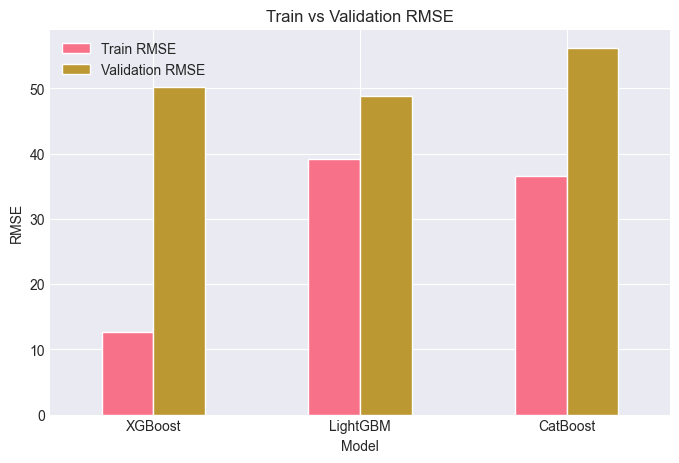

In [68]:
# Create a DataFrame of train vs validation metrics
overfit_df = metrics_df[['Train RMSE', 'Validation RMSE', 'Train MAE', 'Validation MAE', 'Train R2', 'Validation R2']].copy()
overfit_df['RMSE Gap'] = overfit_df['Validation RMSE'] - overfit_df['Train RMSE']
overfit_df['MAE Gap'] = overfit_df['Validation MAE'] - overfit_df['Train MAE']
overfit_df['R2 Gap'] = overfit_df['Validation R2'] - overfit_df['Train R2']

print("Overfitting Indicators (Validation - Train):")
print(overfit_df[['RMSE Gap', 'MAE Gap', 'R2 Gap']])

# Plot train vs validation RMSE
fig, ax = plt.subplots(figsize=(8, 5))
overfit_df[['Train RMSE', 'Validation RMSE']].plot(kind='bar', ax=ax)
ax.set_title('Train vs Validation RMSE')
ax.set_ylabel('RMSE')
ax.set_xlabel('Model')
plt.xticks(rotation=0)
plt.show()

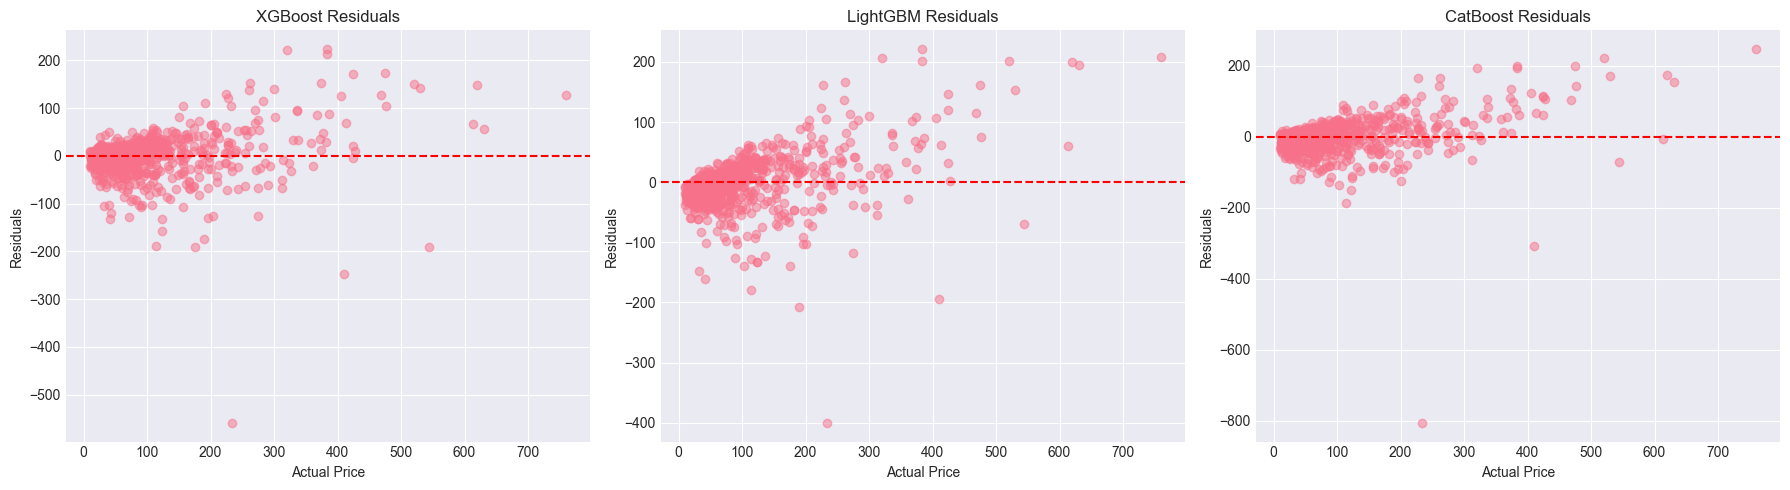

In [69]:
# Create residuals for each model
residuals = {
    'XGBoost': y_val - xgb_val_pred,
    'LightGBM': y_val - lgb_val_pred,
    'CatBoost': y_val - cb_val_pred
}

# Plot residuals
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, resid) in zip(axes, residuals.items()):
    ax.scatter(y_val, resid, alpha=0.5)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(f'{name} Residuals')
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Residuals')

plt.tight_layout()
plt.show()

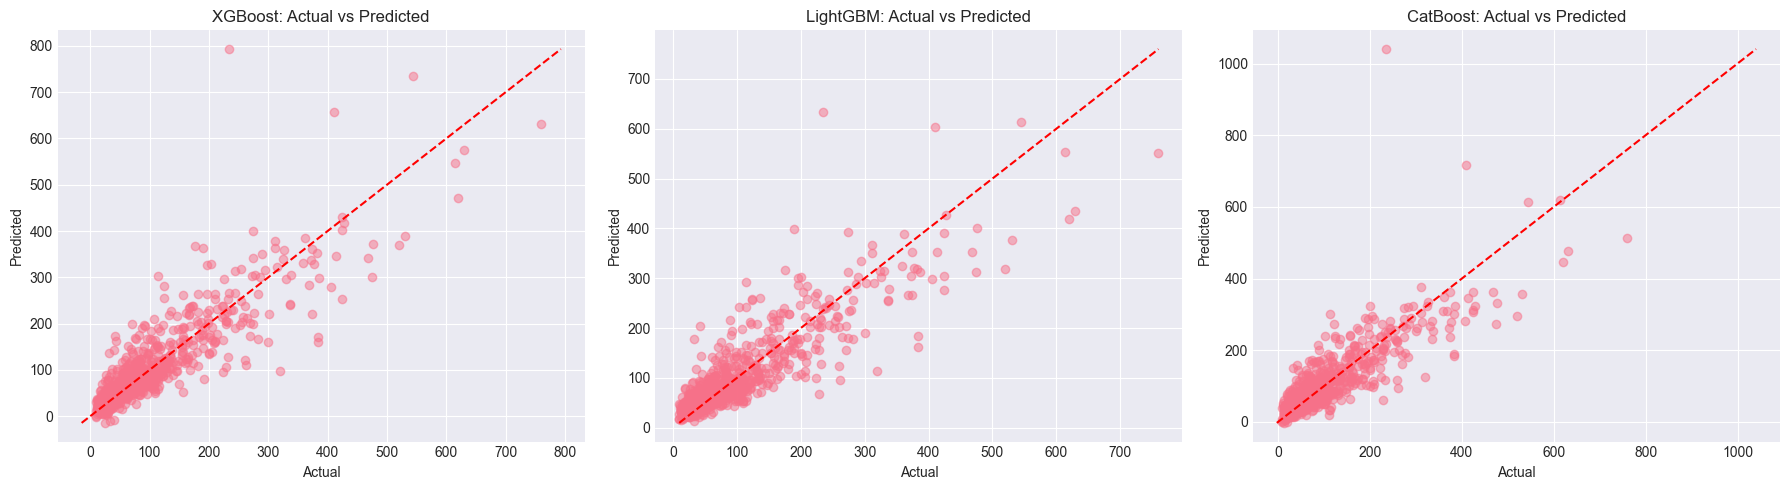

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

predictions = {
    'XGBoost': xgb_val_pred,
    'LightGBM': lgb_val_pred,
    'CatBoost': cb_val_pred
}

for ax, (name, pred) in zip(axes, predictions.items()):
    ax.scatter(y_val, pred, alpha=0.5)
    # Perfect prediction line
    min_val = min(y_val.min(), pred.min())
    max_val = max(y_val.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    ax.set_title(f'{name}: Actual vs Predicted')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

plt.tight_layout()
plt.show()

In [71]:
import joblib
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Helper function to compute test metrics if not already available ---
def get_test_metrics(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Computed test metrics for {model_name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
    return rmse, mae, r2

# Check and compute test metrics if needed
try:
    test_xgb
except NameError:
    print("test_xgb not found. Computing now...")
    test_xgb = get_test_metrics(xgb_model, X_test, y_test, "XGBoost")

try:
    test_lgb
except NameError:
    print("test_lgb not found. Computing now...")
    test_lgb = get_test_metrics(lgb_model, X_test, y_test, "LightGBM")

try:
    test_cb
except NameError:
    print("test_cb not found. Computing now...")
    test_cb = get_test_metrics(cb_model, X_test, y_test, "CatBoost")

# --- Compile metrics into a comparison DataFrame ---
comparison = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost'],
    'Train RMSE': [xgb_metrics['Train RMSE'], lgb_metrics['Train RMSE'], cb_metrics['Train RMSE']],
    'Validation RMSE': [xgb_metrics['Validation RMSE'], lgb_metrics['Validation RMSE'], cb_metrics['Validation RMSE']],
    'Test RMSE': [test_xgb[0], test_lgb[0], test_cb[0]],
    'Train MAE': [xgb_metrics['Train MAE'], lgb_metrics['Train MAE'], cb_metrics['Train MAE']],
    'Validation MAE': [xgb_metrics['Validation MAE'], lgb_metrics['Validation MAE'], cb_metrics['Validation MAE']],
    'Test MAE': [test_xgb[1], test_lgb[1], test_cb[1]],
    'Train R2': [xgb_metrics['Train R2'], lgb_metrics['Train R2'], cb_metrics['Train R2']],
    'Validation R2': [xgb_metrics['Validation R2'], lgb_metrics['Validation R2'], cb_metrics['Validation R2']],
    'Test R2': [test_xgb[2], test_lgb[2], test_cb[2]]
})

# Add overfitting gap (Validation RMSE - Train RMSE)
comparison['Overfitting Gap (RMSE)'] = comparison['Validation RMSE'] - comparison['Train RMSE']
# Relative gap as percentage
comparison['Relative Gap (%)'] = (comparison['Overfitting Gap (RMSE)'] / comparison['Train RMSE']) * 100

print("\n" + "="*60)
print("Model Comparison with Overfitting Indicators")
print("="*60)
print(comparison.round(4).to_string(index=False))

# --- Interpretation of overfitting gap ---
print("\n--- Overfitting Interpretation ---")
print("- A small positive gap indicates slight overfitting (normal).")
print("- A large positive gap suggests significant overfitting.")
print("- A negative gap (validation better than train) is unusual and may indicate data leakage or other issues.")
print("\nBased on the relative gap percentage:")
for idx, row in comparison.iterrows():
    gap_pct = row['Relative Gap (%)']
    if gap_pct < 5:
        verdict = "Low overfitting (good)"
    elif gap_pct < 15:
        verdict = "Moderate overfitting"
    else:
        verdict = "High overfitting (consider regularization)"
    print(f"  {row['Model']}: {gap_pct:.2f}% → {verdict}")

# --- Select best model based on validation RMSE ---
best_model_idx = comparison['Validation RMSE'].idxmin()
best_model_name = comparison.loc[best_model_idx, 'Model']
best_val_rmse = comparison.loc[best_model_idx, 'Validation RMSE']
print(f"\n✅ Best model based on validation RMSE: {best_model_name} (RMSE = {best_val_rmse:.4f})")

# --- Save all models to ../models/baseline_models/ ---
model_dir = "../models/baseline_models"
os.makedirs(model_dir, exist_ok=True)

# Dictionary of model objects
models_to_save = {
    'xgboost_model.pkl': xgb_model,
    'lightgbm_model.pkl': lgb_model,
    'catboost_model.pkl': cb_model
}

for filename, model_obj in models_to_save.items():
    filepath = os.path.join(model_dir, filename)
    joblib.dump(model_obj, filepath)
    print(f"Saved {filename} to {filepath}")

print("\nAll baseline models saved successfully.")


Model Comparison with Overfitting Indicators
   Model  Train RMSE  Validation RMSE  Test RMSE  Train MAE  Validation MAE  Test MAE  Train R2  Validation R2  Test R2  Overfitting Gap (RMSE)  Relative Gap (%)
 XGBoost     12.6092          50.2281    48.0041     9.1820         30.4763   31.2481    0.9863         0.7454   0.7521                 37.6189          298.3438
LightGBM     39.1773          48.7715    47.5154    24.3079         31.2987   31.0960    0.8673         0.7599   0.7571                  9.5942           24.4891
CatBoost     36.6348          56.1925    56.4950    25.3948         32.8548   33.5470    0.8840         0.6813   0.6567                 19.5578           53.3857

--- Overfitting Interpretation ---
- A small positive gap indicates slight overfitting (normal).
- A large positive gap suggests significant overfitting.
- A negative gap (validation better than train) is unusual and may indicate data leakage or other issues.

Based on the relative gap percentage:
  XGBo